In [1]:
pip install gurobi-logtools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 36.4 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Users/yfd/.local/share/mamba/envs/pytorch_env_310/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyomo

  Using cached ply-3.11-py2.py3-none-any.whl.metadata (844 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 10.8 MB/s eta 0:00:00a 0:00:01
Using cached ply-3.11-py2.py3-none-any.whl (49 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Users/yfd/.local/share/mamba/envs/pytorch_env_310/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 11.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Users/yfd/.local/share/mamba/envs/pytorch_env_310/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Core 
import io
import sys
import ast
import re
from pathlib import Path
import glob
import pandas as pd
from itertools import pairwise
from IPython.display import display

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Optimization
import pyomo.environ as pyo
import gurobipy as gp
import gurobi_logtools as glt

In [ ]:
# Cell 1: Utilities
''' Purpose: 
Gives you a structured summary of your Gurobi model:
1. Counts variables by type (e.g., integer, continuous), by name prefix, and bounds.
2. Reports objective direction (minimize/maximize).
3. Groups constraints by base name and sense (equality, ≤, ≥).

Useful when:
1. You're working with large, complex models and want to understand model structure at a glance.
2. You're debugging model generation to check if variables/constraints were created as expected.
3. You're comparing different model formulations. '''

In [19]:
def summarizeGurobiModel(model: gp.Model) -> pd.DataFrame:
    '''
    Summarizes a Gurobi model, grouping variables by name prefix and type,
    and constraints by base name and sense.

    Returns:
        pd.DataFrame: Table with columns [Type, Detail, Name, Count].
    '''
    model.update()  # Ensure model is fully populated

    rows = []

    # Variable types mapping
    var_types = {'C': 'Continuous', 'I': 'Integer', 'B': 'Binary',
                 'S': 'Semi-continuous', 'N': 'Semi-integer'}

    # Group variables by prefix and type
    var_groups = {}
    for var in model.getVars():
        prefix = re.match(r'^[a-zA-Z_]+', var.VarName)
        name_group = prefix.group(0) if prefix else 'unknown'
        vtype = var_types.get(var.VType, 'Other')
        bounds = f"[{var.LB}, {var.UB}]"
        key = (name_group, f'{vtype} {bounds}')
        var_groups[key] = var_groups.get(key, 0) + 1

    for (name, detail), count in var_groups.items():
        rows.append({'Type': 'Var', 'Detail': detail, 'Name': name, 'Count': count})

    # Objective
    sense = 'minimize' if model.ModelSense == 1 else 'maximize'
    rows.append({'Type': 'Objective', 'Detail': sense, 'Name': 'obj', 'Count': 1})

    # Constraint types
    sense_map = {'=': 'equality', '<': 'inequality (<=)', '>': 'inequality (>=)'}
    constrs = model.getConstrs()
    constr_names = model.getAttr('ConstrName', constrs)
    constr_senses = model.getAttr('Sense', constrs)

    # Group constraints by base name and sense
    grouped = {}
    for name, sense in zip(constr_names, constr_senses):
        base_name = re.sub(r'\[.*\]', '', name)
        detail = sense_map.get(sense, 'other')
        grouped[(base_name, detail)] = grouped.get((base_name, detail), 0) + 1

    for (name, detail), count in grouped.items():
        rows.append({'Type': 'Constraint', 'Detail': detail, 'Name': name, 'Count': count})

    return pd.DataFrame(rows).reset_index(drop=True)


def getGurobiParameterNames() -> list[str]:
    """
    Captures and parses the full list of Gurobi parameter names by redirecting stdout
    from `model.getParamInfo('*')`, which normally prints to the console.

    Returns:
        A list of parameter names as strings.

    Purpose: Captures all available Gurobi parameter names, using a workaround since Gurobi prints to stdout. Useful when:
        1. You want to inspect or reset solver parameters programmatically.
        2. You're building tooling around Gurobi that includes parameter tuning.
    """
    model = gp.Model()
    buffer = io.StringIO()
    sys_stdout = sys.stdout
    try:
        sys.stdout = buffer
        model.getParamInfo('*')  # Prints param info to stdout
    finally:
        sys.stdout = sys_stdout

    s = buffer.getvalue()
    start = s.index('[')
    end = s.index(']', start) + 1
    param_names = set(ast.literal_eval(s[start:end])) - {'LicenseID','Username'}
    return sorted(param_names)

def dictToNamedValueString(d: dict) -> str:
    """
    Converts a dictionary of parameter names and values to a safe string
    for filenames or identifiers, e.g., MIPGap_0_01__TimeLimit_600

    Args:
        d: Dictionary with key-value pairs.

    Returns:
        A string with key-value pairs joined using underscores and double underscores.

    Purpose:
        This function can be used to systematically label each configuration in a way that’s easy to parse and trace later
    """
    parts = []
    for k, v in sorted(d.items()):
        parts.append(f'{k}={v}')
    return '_'.join(parts)


def getGurobiNonDefaultParamsString(model: gp.Model) -> str:
    """
    Returns a filename-safe string representing non-default Gurobi parameters.

    Args:
        model: Gurobi model

    Returns:
        A string suitable for filenames, like: "MIPGap_0_01__TimeLimit_600"

    Purpose: Lists non-default solver parameters in a filename-safe string. Useful when:
        1. You're logging or saving model runs and want to encode solver settings in filenames for reproducibility.
        2. You’re comparing results under different solver settings.
    """
    nonDefaultParams = []
    
    for name in getGurobiParameterNames():
        try:
            _, _, value, _, _, default = model.getParamInfo(name)
            if value != default:
                print(f'{name}: {value} {default}')
                nonDefaultParams.append(f'{name}={value}')
        except Exception as e:
            print(f'Error with parameter {name}: {e}')
            continue  # Skip params not supported in current context
    return '_'.join(nonDefaultParams)

def resetAllGurobiParams(model: gp.Model) -> None:
    """
    Resets all known Gurobi parameters to their default values for a given model.

    Args:
        model: An instance of a Gurobi model.
    Purpose: Resets all changed solver parameters back to defaults. Useful when:
        1. You’re running multiple models in a loop or across experiments, and want to ensure each run starts from a clean slate.
        2. You’ve been tuning parameters and want to undo changes.
    """
    for name in getGurobiParameterNames():
        try:
            # getParamInfo returns: name, type, current, min, max, default
            _, _, value, _, _, default = model.getParamInfo(name)
            if value != default:
                model.setParam(name, default)
        except Exception as e:
            print(f"Skipping parameter {name} due to error: {e}")
            continue


In [25]:
def summarizePyomoModel(model: pyo.ConcreteModel) -> pd.DataFrame:
    '''
    Creates a detailed summary of a Pyomo model.

    For each major component (variables, objectives, constraints, parameters, sets),
    the summary includes:
    - Variables: type and bounds
    - Objectives: sense (minimize or maximize)
    - Constraints: equality or inequality
    - Parameters: scalar/indexed, mutable/fixed
    - Sets: dimension and ordering

    Args:
        model (pyo.ConcreteModel): A Pyomo concrete model.

    Returns:
        pd.DataFrame: Summary table with columns [Type, Detail, Name, Count].
    '''
    rows = []

    # Variables
    for var in model.component_objects(pyo.Var, active=True):
        var_data = list(var.values())
        count = len(var_data)
        if count == 0:
            detail = 'empty'
        else:
            sample = var_data[0]
            if sample.is_binary():
                detail = 'Binary'
            else:
                lb = sample.lb
                ub = sample.ub
                if lb is None and ub is None:
                    bounds_str = 'unbounded'
                elif lb is None:
                    bounds_str = f'(-inf, {ub}]'
                elif ub is None:
                    bounds_str = f'[{lb}, inf)'
                else:
                    bounds_str = f'[{lb}, {ub}]'
                detail = f"{sample.domain.name} {bounds_str}"
        rows.append({'Type': 'Var', 'Detail': detail, 'Name': var.name, 'Count': count})

    # Objectives
    for obj in model.component_objects(pyo.Objective, active=True):
        sense = 'minimize' if obj.sense == pyo.minimize else 'maximize'
        rows.append({'Type': 'Objective', 'Detail': sense, 'Name': obj.name, 'Count': 1})

    # Constraints
    for con in model.component_objects(pyo.Constraint, active=True):
        con_data = list(con.values())
        count = len(con_data)
        if count == 0:
            detail = 'empty'
        else:
            sample = con_data[0]
            detail = 'equality' if sample.equality else 'inequality'
        rows.append({'Type': 'Constraint', 'Detail': detail, 'Name': con.name, 'Count': count})

    # Parameters
    for param in model.component_objects(pyo.Param, active=True):
        param_data = list(param.values())
        count = len(param_data)
        if count == 0:
            detail = 'empty'
        else:
            detail = 'mutable' if param.mutable else 'fixed'
        rows.append({'Type': 'Param', 'Detail': detail, 'Name': param.name, 'Count': count})

    # Sets
    for s in model.component_objects(pyo.Set, active=True):
        count = len(s)
        detail = f"dim={s.dimen}, {'ordered' if s.isordered() else 'unordered'}"
        rows.append({'Type': 'Set', 'Detail': detail, 'Name': s.name, 'Count': count})

    # Custom order for readability
    type_order = {'Set': 0, 'Param': 1, 'Var': 2, 'Objective': 3, 'Constraint': 4}

    return (
        pd.DataFrame(rows)
        .assign(_order=lambda df: df['Type'].map(type_order))
        .sort_values(by=['_order', 'Name'])
        .drop(columns='_order')
        .reset_index(drop=True)
    )

def getPyomoSolverOptionsString(solver) -> str:
    """
    Generates a filename-friendly string summarizing the user-set solver options.

    Args:
        solver: A Pyomo SolverFactory instance with `.options` set.

    Returns:
        str: Concatenated string of option names and values, safe for filenames.
    """
    return dictToNamedValueString(solver.options)

In [8]:
# Cell 2: Data reading function
def readTaxModelData(
    filepath: str, 
    sheetName: str = 'Sheet1', 
    nRows: int | None = None
) -> pd.DataFrame:
    '''
    Reads taxpayer data and group mappings from Excel.

    Args:
        filepath (str): Path to Excel file.
        sheetName (str): Sheet name containing taxpayer data.
        nRows (int, optional): Number of rows to read from the sheet. If None, reads all rows.

    Returns:
        data (pd.DataFrame): Main data table.
    '''
    return pd.read_excel(
        filepath, 
        sheet_name=sheetName, 
        index_col=0, 
        nrows=nRows
    ).reset_index(drop=True)

In [9]:
# Cell 3: Cutoff generation
def generateCutoffs(data: pd.DataFrame, step: float = 500.0) -> dict[int, float]:
    '''
    Generates bracket cutoffs in evenly spaced steps (e.g., €500), up to and beyond the maximum income.

    Args:
        data (pd.DataFrame): Input data with 'income_before_tax'.
        step (float): Step size for cutoffs (default: €500).

    Returns:
        dict[int, float]: A mapping {0: 0.0, 1: step, ..., K: upper bound},
                          where K is the smallest index such that cutoffs[K] >= max(income).
    '''
    maxIncome = data['income_before_tax'].max()
    upperBound = ((maxIncome // step) + 1) * step  # round up to nearest full step
    cutoffsList = [i * step for i in range(int(upperBound // step) + 1)]
    return {i: c for i, c in enumerate(cutoffsList)}

In [65]:
# Cell 4: Gamma computation
def computeGammaDict(
    data: pd.DataFrame,
    cutoffs: dict[int, float]
) -> dict[tuple[int, int], float]:
    '''
    Computes gamma[i, b] = max(0, min(chi[i], upper) - lower) for each taxpayer i and bracket b.

    Args:
        data (pd.DataFrame): Input data with 'income_before_tax'.
        cutoffs (dict[int, float]): Bracket cutoff values with keys in order, e.g., {0: 0.0, 1: 5000.0, ...}.

    Returns:
        dict[tuple[int, int], float]: Dictionary mapping (i, b) to gamma[i, b].
    '''
    gammaDict = {}
    for i, row in data.iterrows():
        chi = row['income_before_tax']
        for b, (lower, upper) in enumerate(pairwise(cutoffs.values()), start=1):
            gammaDict[(i, b)] = max(0.0, min(chi, upper) - lower)
    return gammaDict

In [135]:
# Cell 5.a: Gurobipy model setup
def buildBracketModelGurobi(
    data: pd.DataFrame,
    cutoffs: dict[int, float],
    gammaDict: dict[tuple[int, int], float],
    maxBrackets: int = 4,
    allowNegativeD: bool = True,
    minimizeMaxSlack: bool = False  # NEW
) -> gp.Model:
    '''
    Constructs a Gurobi model for optimizing tax brackets under fairness criteria.

    Args:
        data (pd.DataFrame): Input data with 'income_before_tax', 'outcome_2', and 'tax_group'.
        cutoffs (dict[int, float]): Cutoff boundaries for candidate brackets, keys are 0..B.
        gammaDict (dict[tuple[int, int], float]): (taxpayer, bracket) -> gamma values.
        maxBrackets (int): Max number of activated brackets.
        allowNegativeD (bool): Whether d[b] (rate increment) can be negative.
        minimizeMaxSlack (bool): If True, minimizes the maximum slack instead of the sum.

    Returns:
        gp.Model: Fully constructed Gurobi model.
    '''
    model = gp.Model('bracket_model')

    taxpayers = list(data.index)
    groups = sorted(data['tax_group'].unique())
 
    #bracketIndices = cutoffs.keys()[:-1]        # [0, ..., 29]
    #bracketIndicesNoLast = bracketIndices[:-1]  # [0, ..., 28]
    
    bracketIndices = list(range(1, max(cutoffs.keys()) + 1))
    bracketIndicesNoLast = bracketIndices[:-1]

    # Parameters
    chi = data['income_before_tax'].to_dict()
    omega = data['outcome_2'].to_dict()
    psi_obs = {i: chi[i] - omega[i] for i in taxpayers}
    gamma = gammaDict
    g_i = data['tax_group'].to_dict()

    # Decision variables
    r = model.addVars(groups, bracketIndices, lb=0, ub=1, name='r')
    d_bounds = (-1, 1) if allowNegativeD else (0, 1)
    #d = model.addVars(bracketIndicesNoLast, lb=d_bounds[0], ub=d_bounds[1], name='d')
    #w = model.addVars(bracketIndicesNoLast, vtype=gp.GRB.BINARY, name='w')
    d = model.addVars(groups, bracketIndicesNoLast, lb=d_bounds[0], ub=d_bounds[1], name='d')
    w = model.addVars(groups, bracketIndicesNoLast, vtype=gp.GRB.BINARY, name='w')
    s = model.addVars(taxpayers, lb=0, name='s')

    # Objective
    if minimizeMaxSlack:
        z = model.addVar(lb=0.0, name='z')
        model.setObjective(z, gp.GRB.MINIMIZE)
        model.addConstrs((z >= s[i] for i in taxpayers), name='max_slack')
    else:
        model.setObjective(gp.quicksum(s[i] for i in taxpayers), gp.GRB.MINIMIZE)

    # Constraints
    model.addConstrs(
        (gp.quicksum(r[g_i[i], b] * gamma[i, b] for b in bracketIndices) - psi_obs[i] >= -s[i]
         for i in taxpayers),
        name='psi_lo'
    )

    model.addConstrs(
        (gp.quicksum(r[g_i[i], b] * gamma[i, b] for b in bracketIndices) - psi_obs[i] <= s[i]
         for i in taxpayers),
        name='psi_hi'
    )

    model.addConstrs(
        (r[g, b + 1] == r[g, b] + d[g, b] for g in groups for b in bracketIndicesNoLast),
        name='rate_incr'
    )
    

    model.addConstrs(
        (d[g, b] <= w[g, b] for g in groups for b in bracketIndicesNoLast), 
        name='incr_up'
    )
 
    if allowNegativeD:
        model.addConstrs(
            (d[g, b] >= -w[g, b] for g in groups for b in bracketIndicesNoLast), 
             name='incr_down'
        )


    model.addConstrs(
        (gp.quicksum(w[g, b] for b in bracketIndicesNoLast) <= maxBrackets[g] for g in groups),
        name='group_active'
    )


    '''
    ### with global number of activated brackets
    model.addConstrs(
        (r[g, b + 1] == r[g, b] + d[b] for g in groups for b in bracketIndicesNoLast),
        name='rate_incr'
    )


    model.addConstrs(
        (d[b] <= w[b] for b in bracketIndicesNoLast),
        name='incr_up'
    )

    if allowNegativeD:
        model.addConstrs(
            (d[b] >= -w[b] for b in bracketIndicesNoLast),
            name='incr_down'
        )
    
    model.addConstr(
        gp.quicksum(w[b] for b in bracketIndicesNoLast) <= maxBrackets,
        name='total_active'
    )
    '''
    
    return model


In [160]:
options = dict(
    nRows=None, # None: all rows, int: number of rows to read
    #maxBrackets=4,  # Maximum number of activated brackets
    maxBrackets={1: 4, 2: 4, 3: 4, 4: 4},  # group-specific limits
    minmax=False,  # True: minimize max slack, False: minimize total slack
    dNegs=False,  # True: allow negative rate increments, False: only non-negative
    scale=1000.0,  # Scaling factor for monetary values
    step=5.0,  # Step size for cutoffs (e.g., €5000) should respect the scale
    time_limit=900,  # Time limit for solver in seconds
    mip_gap=0.001,  # MIP gap for solver
    groups=[1,2,3,4],  # List of tax groups to include (None: all groups)
)

In [161]:
# Cell 7: Read and scale data
filepath = 'simple_simul_100k.xlsx'
data = readTaxModelData(filepath,nRows=options['nRows'])

for col in data.columns:
    if col.startswith('outcome_') or col == 'income_before_tax':
        data[col] = data[col] / options['scale']
    elif col == 'tax_group':
        data[col] = data[col].astype('category')

if options['groups'] is not None:
    data = data[data['tax_group'].isin(options['groups'])].reset_index(drop=True)

In [162]:
print("Unique tax groups in data:", sorted(data['tax_group'].unique()))
print("Group counts:\n", data['tax_group'].value_counts())

Unique tax groups in data: [1, 2, 3, 4]
Group counts:
 tax_group
3    25182
1    24957
2    24951
4    24910
Name: count, dtype: int64


<Axes: xlabel='household_size'>

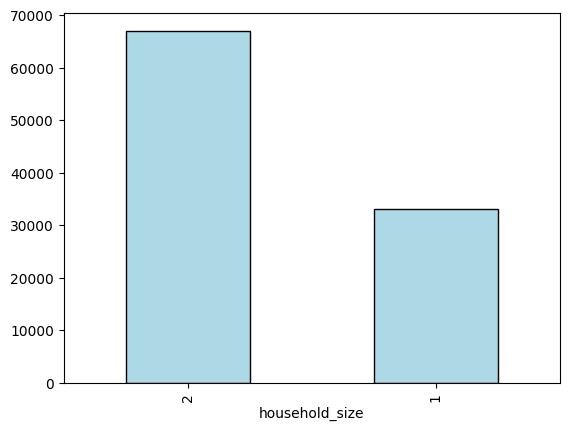

In [163]:
data['household_size'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')

In [164]:
# Cell 8: Generate cutoffs
cutoffs = generateCutoffs(data, step=options['step'])
gammaDict = computeGammaDict(data, cutoffs)
len(cutoffs)

31

In [165]:
M = buildBracketModelGurobi(
    data, cutoffs, gammaDict, 
    maxBrackets=options['maxBrackets'], 
    allowNegativeD=options['dNegs'],
    minimizeMaxSlack=options['minmax']
)

M.update()

summarizeGurobiModel(M)

,Type,Detail,Name,Count
0,Var,"Continuous [0.0, 1.0]",r,120
1,Var,"Continuous [0.0, 1.0]",d,116
2,Var,"Binary [0.0, 1.0]",w,116
3,Var,"Continuous [0.0, inf]",s,100000
4,Objective,minimize,obj,1
5,Constraint,inequality (>=),psi_lo,100000
6,Constraint,inequality (<=),psi_hi,100000
7,Constraint,equality,rate_incr,116
8,Constraint,inequality (<=),incr_up,116
9,Constraint,inequality (<=),group_active,4


In [166]:
import re

def makeFilenameSafe(s: str) -> str:
    """
    Converts a string into a safe format for use as a filename.
    
    Replaces or removes characters that are unsafe in filenames across OSes.
    Examples of removed/replaced characters: / \ : * ? " < > | [ ] , = and whitespace
    
    Parameters:
        s (str): The input string
    
    Returns:
        str: A sanitized, filename-safe string
    """
    # Replace spaces with underscores
    s = s.replace(' ', '_')

    # Replace list brackets and commas if present
    s = s.replace('[', '').replace(']', '')
    s = s.replace(',', '_')

    # Replace equal signs with dash for better readability
    s = s.replace('=', '-')

    # Remove characters not allowed in filenames on most OSes
    s = re.sub(r'[<>:"/\\|?*]', '', s)

    # Collapse multiple underscores
    s = re.sub(r'__+', '_', s)

    return s.strip('_')


In [167]:
M.reset()                                # Reset model state (clears solution, basis, etc.)
resetAllGurobiParams(M)                  # Restore all Gurobi parameters to default values

M.Params.OutputFlag = 1                  # Enable solver output to console
M.Params.MIPGap = options['mip_gap']                   # Set relative MIP optimality gap to 1%
M.Params.TimeLimit = options['time_limit']          # Limit total solve time (in seconds)

# Focused configuration to potentially beat the current best time
M.Params.Method = 2                      # Use barrier method for root LP
M.Params.Crossover = 1                   # Enable crossover to ensure integer solution (required for MIP)
M.Params.MIPFocus = 1                    # Emphasize finding good feasible solutions early
M.Params.NoRelHeurTime = 10              # Allocate time to NoRel heuristic before branch-and-bound
M.Params.Presolve = 0                    # Disable presolve (saves time, model is already clean)

M.Params.LogFile = makeFilenameSafe( f'Gurobi_{dictToNamedValueString(options)}_{getGurobiNonDefaultParamsString(M)}.log' )  # Log file naming
M.optimize()                             # Start the optimization

M.Params.LogFile = ''                    # Close the current log file (release file handle without destroying model)




Discarded solution information
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 900
Set parameter Method to value 2
Set parameter Crossover to value 1
Set parameter MIPFocus to value 1
Set parameter NoRelHeurTime to value 10
Set parameter Presolve to value 0
Crossover: 1 -1
MIPFocus: 1 0
MIPGap: 0.001 0.0001
Method: 2 -1
NoRelHeurTime: 10.0 0.0
Presolve: 0 -1
TimeLimit: 900.0 inf
Set parameter LogFile to value "Gurobi_dNegs-False_groups-1_2_3_4_maxBrackets-{1_4_2_4_3_4_4_4}_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_Crossover-1_MIPFocus-1_MIPGap-0.001_Method-2_NoRelHeurTime-10.0_Presolve-0_TimeLimit-900.0.log"
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[x86] - Darwin 24.3.0 24D81)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.001
Method  2
Crossover  1
MI

In [168]:
M.reset()                                # Reset the model state (clears solution, basis, etc.)
resetAllGurobiParams(M)                  # Restore all Gurobi parameters to their default values

M.Params.OutputFlag = 1                  # Enable solver output to the console
M.Params.MIPGap = options['mip_gap']                   # Set relative MIP optimality gap to 1%
M.Params.TimeLimit = options['time_limit']          # Set maximum solve time (in seconds)

M.Params.LogFile = makeFilenameSafe( f'Gurobi_{dictToNamedValueString(options)}_{getGurobiNonDefaultParamsString(M)}.log' )  # Set log file name based on parameter settings

M.optimize()                             # Start the optimization

M.Params.LogFile = ''                    # Close the current log file (release file handle without destroying model)

Discarded solution information
Set parameter Crossover to value -1
Set parameter MIPFocus to value 0
Set parameter MIPGap to value 0.0001
Set parameter Method to value -1
Set parameter NoRelHeurTime to value 0
Set parameter Presolve to value -1
Set parameter TimeLimit to value 1e+100
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 900
MIPGap: 0.001 0.0001
TimeLimit: 900.0 inf
Set parameter LogFile to value "Gurobi_dNegs-False_groups-1_2_3_4_maxBrackets-{1_4_2_4_3_4_4_4}_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_MIPGap-0.001_TimeLimit-900.0.log"
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[x86] - Darwin 24.3.0 24D81)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.001

Optimize a model with 200236 rows, 100352 columns and 3299062 nonzeros
Model fingerprint:

In [169]:
M.reset()                                # Reset the model state (clears any previous solve status)
resetAllGurobiParams(M)                  # Restore all Gurobi parameters to their default values

M.Params.OutputFlag = 1                  # Enable solver output to the console
M.Params.MIPGap = options['mip_gap']                   # Set relative MIP optimality gap to 1%
M.Params.NoRelHeurTime = 10              # Allocate time to NoRel heuristic before solving
M.Params.Presolve = 0                    # Disable presolve to avoid long preprocessing (model is clean)
M.Params.TimeLimit = options['time_limit']          # Set maximum solve time (in seconds)
M.Params.MIPFocus = 1                    # Focus on finding good feasible solutions early

M.Params.LogFile = makeFilenameSafe( f'Gurobi_{dictToNamedValueString(options)}_{getGurobiNonDefaultParamsString(M)}.log' )  # Set the Gurobi log file
M.optimize()                             # Start the optimization

M.Params.LogFile = ''                    # Close the current log file (release file handle without destroying model)


Discarded solution information
Set parameter MIPGap to value 0.0001
Set parameter TimeLimit to value 1e+100
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.001
Set parameter NoRelHeurTime to value 10
Set parameter Presolve to value 0
Set parameter TimeLimit to value 900
Set parameter MIPFocus to value 1
MIPFocus: 1 0
MIPGap: 0.001 0.0001
NoRelHeurTime: 10.0 0.0
Presolve: 0 -1
TimeLimit: 900.0 inf
Set parameter LogFile to value "Gurobi_dNegs-False_groups-1_2_3_4_maxBrackets-{1_4_2_4_3_4_4_4}_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_MIPFocus-1_MIPGap-0.001_NoRelHeurTime-10.0_Presolve-0_TimeLimit-900.0.log"
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[x86] - Darwin 24.3.0 24D81)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.001
MIPFocus  1
NoRelHeurTime  10
Presolve  0

Optimize a model with 

In [170]:
def buildBracketModel(
    data: pd.DataFrame,
    cutoffs: dict[int, float],
    gammaDict: dict[tuple, float],
    maxBrackets: int = 4,
    allowNegativeD: bool = True,
    minimizeMaxSlack: bool = False
) -> pyo.ConcreteModel:
    '''
    Constructs a Pyomo model for optimizing tax brackets under fairness criteria.

    Args:
        data (pd.DataFrame): Input data with 'income_before_tax', 'outcome_2', and 'tax_group'.
        cutoffs (dict[int, float]): Bracket cutoff values with keys from 0 to B.
        gammaDict (dict[tuple, float]): Mapping (taxpayer, bracket) to gamma value.
        maxBrackets (int): Maximum number of activated brackets.
        allowNegativeD (bool): Whether rate increments can be negative.
        minimizeMaxSlack (bool): If True, minimize max slack instead of total slack.

    Returns:
        pyo.ConcreteModel: Fully constructed Pyomo model.
    '''
    model = pyo.ConcreteModel()

    # Index sets
    bracketIndices = list(range(1, max(cutoffs.keys()) + 1))
    bracketIndicesNoLast = bracketIndices[:-1]
    
    model.groups = pyo.Set(initialize=sorted(data['tax_group'].unique()))
    model.candidate_brackets = pyo.Set(initialize=bracketIndices, ordered=True)
    model.candidate_brackets_no_last = pyo.Set(initialize=bracketIndicesNoLast, ordered=True)
    model.taxpayers = pyo.Set(initialize=list(data.index))

    # Parameters
    model.chi = pyo.Param(model.taxpayers, initialize=data['income_before_tax'].to_dict(), within=pyo.NonNegativeReals)
    model.omega = pyo.Param(model.taxpayers, initialize=data['outcome_2'].to_dict(), within=pyo.NonNegativeReals)
    model.psi_obs = pyo.Param(model.taxpayers,
        initialize=(data['income_before_tax'] - data['outcome_2']).to_dict(), within=pyo.NonNegativeReals)
    model.varphi = pyo.Param(model.candidate_brackets,
        initialize={b: cutoffs[b] for b in bracketIndices}, within=pyo.NonNegativeReals)
    model.gamma = pyo.Param(model.taxpayers, model.candidate_brackets, initialize=gammaDict, within=pyo.NonNegativeReals)
    model.g_i = pyo.Param(model.taxpayers, initialize=data['tax_group'].to_dict(), within=model.groups)
    
    # Variables
    model.r = pyo.Var(model.groups, model.candidate_brackets, bounds=(0, 1))
    #model.d = pyo.Var(model.candidate_brackets_no_last,
                      #domain=pyo.Reals if allowNegativeD else pyo.NonNegativeReals,
                      #bounds=(-1, 1) if allowNegativeD else (0, 1))
    #model.w = pyo.Var(model.candidate_brackets_no_last, domain=pyo.Binary)
    model.d = pyo.Var(model.groups, model.candidate_brackets_no_last,
                      domain=pyo.Reals if allowNegativeD else pyo.NonNegativeReals,
                      bounds=(-1, 1) if allowNegativeD else (0, 1))
    model.w = pyo.Var(model.groups, model.candidate_brackets_no_last, domain=pyo.Binary)
    
    model.s = pyo.Var(model.taxpayers, domain=pyo.NonNegativeReals)

    if minimizeMaxSlack:
        model.z = pyo.Var(domain=pyo.NonNegativeReals)

    # Objective
    @model.Objective(sense=pyo.minimize)
    def objective(m):
        return m.z if minimizeMaxSlack else sum(m.s[i] for i in m.taxpayers)

    # Max slack constraint
    @model.Constraint(model.taxpayers)
    def max_slack(m, i):
        if minimizeMaxSlack:
            return m.z >= m.s[i]
        return pyo.Constraint.Skip

    # Expression
    @model.Expression(model.taxpayers)
    def tax_pressure(m, i):
        g = m.g_i[i]
        return sum(m.r[g, b] * m.gamma[i, b] for b in m.candidate_brackets) - m.psi_obs[i]

    # Constraints (split for solver compatibility)
    @model.Constraint(model.taxpayers)
    def tax_pressure_lower(m, i):
        return m.tax_pressure[i] >= -m.s[i]

    @model.Constraint(model.taxpayers)
    def tax_pressure_upper(m, i):
        return m.tax_pressure[i] <= m.s[i]

    # Rate increment
    @model.Constraint(model.groups, model.candidate_brackets_no_last)
    def rate_increment(m, g, b):
        return m.r[g, b + 1] == m.r[g, b] + m.d[g,b]

    # Increment activation (upper bound)
    @model.Constraint(model.groups, model.candidate_brackets_no_last)
    def increment_activation_up(m, g, b):
        return m.d[g,b] <= m.w[g,b]

    # Increment activation (lower bound, conditional)
    @model.Constraint(model.groups, model.candidate_brackets_no_last)
    def increment_activation_down(m, g, b):
        if allowNegativeD:
            return m.d[g,b] >= -m.w[g,b]
        return pyo.Constraint.Skip

    # Total active brackets
    model.maxBrackets = maxBrackets  # Store for access inside constraint

    @model.Constraint(model.groups)
    def total_activated_brackets(m,g):
        return sum(m.w[g,b] for b in m.candidate_brackets_no_last) <= m.maxBrackets[g]
    return model
'''
    # Rate increment
    @model.Constraint(model.groups, model.candidate_brackets_no_last)
    def rate_increment(m, g, b):
        return m.r[g, b + 1] == m.r[g, b] + m.d[b]

    # Increment activation (upper bound)
    @model.Constraint(model.candidate_brackets_no_last)
    def increment_activation_up(m, b):
        return m.d[b] <= m.w[b]

    # Increment activation (lower bound, conditional)
    @model.Constraint(model.candidate_brackets_no_last)
    def increment_activation_down(m, b):
        if allowNegativeD:
            return m.d[b] >= -m.w[b]
        return pyo.Constraint.Skip

    # Total active brackets
    @model.Constraint()
    def total_activated_brackets(m):
        return sum(m.w[b] for b in m.candidate_brackets_no_last) <= maxBrackets
'''


'\n    # Rate increment\n    @model.Constraint(model.groups, model.candidate_brackets_no_last)\n    def rate_increment(m, g, b):\n        return m.r[g, b + 1] == m.r[g, b] + m.d[b]\n\n    # Increment activation (upper bound)\n    @model.Constraint(model.candidate_brackets_no_last)\n    def increment_activation_up(m, b):\n        return m.d[b] <= m.w[b]\n\n    # Increment activation (lower bound, conditional)\n    @model.Constraint(model.candidate_brackets_no_last)\n    def increment_activation_down(m, b):\n        if allowNegativeD:\n            return m.d[b] >= -m.w[b]\n        return pyo.Constraint.Skip\n\n    # Total active brackets\n    @model.Constraint()\n    def total_activated_brackets(m):\n        return sum(m.w[b] for b in m.candidate_brackets_no_last) <= maxBrackets\n'

In [171]:
# Cell 9: Setup the Pyomo model
model = buildBracketModel(
    data, cutoffs, gammaDict, 
    maxBrackets=options['maxBrackets'], 
    allowNegativeD=options['dNegs'],
    minimizeMaxSlack=options['minmax']
)

In [172]:
summarizePyomoModel(model)

,Type,Detail,Name,Count
0,Set,"dim=1, ordered",candidate_brackets,30
1,Set,"dim=1, ordered",candidate_brackets_no_last,29
2,Set,"dim=1, ordered",groups,4
3,Set,"dim=1, ordered",taxpayers,100000
4,Param,fixed,chi,100000
5,Param,fixed,g_i,100000
6,Param,fixed,gamma,3000000
7,Param,fixed,omega,100000
8,Param,fixed,psi_obs,100000
9,Param,fixed,varphi,30


In [173]:
solver = pyo.SolverFactory('gurobi_direct')
solver.options['mipgap'] = options['mip_gap']  # Set the MIP gap for Gurobi
solver.options['TimeLimit'] = options['time_limit']  # Set the time limit for Gurobi
solver.options['NoRelHeurTime'] = 10  # 10 seconds for the NoRel heuristic
solver.options['MIPFocus'] = 1  # Focus on finding feasible solutions
solver.options['LogFile'] = makeFilenameSafe( f'Pyomo_{dictToNamedValueString(options)}_{getPyomoSolverOptionsString(solver)}.log' ) # Set the Gurobi log file

results = solver.solve(model, tee=True)
print("Solver Status:", results.solver.termination_condition)

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 900
Set parameter NoRelHeurTime to value 10
Set parameter MIPFocus to value 1
Set parameter LogFile to value "Pyomo_dNegs-False_groups-1_2_3_4_maxBrackets-{1_4_2_4_3_4_4_4}_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_MIPFocus-1_NoRelHeurTime-10_TimeLimit-900_mipgap-0.001.log"
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[x86] - Darwin 24.3.0 24D81)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.001
MIPFocus  1
NoRelHeurTime  10

Optimize a model with 200236 rows, 100352 columns and 3299062 nonzeros
Model fingerprint: 0xcb4400c3
Variable types: 100236 continuous, 116 integer (116 binary)
Coefficient statistics:
  Matrix range     [1e-03, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]


In [174]:
# Objective value
optimal_obj = model.objective()
print(f"Optimal objective value (sum of slack): {optimal_obj:.2f}")

# Identify activated brackets
selected_brackets = sorted(
    b for g in model.groups for b in model.candidate_brackets_no_last if pyo.value(model.w[g,b]) > 0.5
)
print(f"Selected bracket breakpoints (indices): {selected_brackets}")
print(f"Number of activated brackets: {len(selected_brackets)}")


# Corresponding cutoff incomes
selected_cutoffs = [round(pyo.value(model.varphi[b]), 2) for b in selected_brackets]
print(f"Selected cutoff incomes: {selected_cutoffs}")

# Extract tax rates per group using cutoff values as column labels
selected_rates_by_group = {
    g: {round(pyo.value(model.varphi[b]), 2): round(pyo.value(model.r[g, b]), 4) for b in selected_brackets}
    for g in model.groups
}

# Display as DataFrame
df_rates = pd.DataFrame.from_dict(selected_rates_by_group, orient='index')
df_rates.columns.name = "Cutoff Income (€)"
df_rates.index.name = "Group"

display(df_rates.round(2))

model.objective(),min(model.s.get_values().values()),max(model.s.get_values().values()),sum(model.s.get_values().values()),len(model.s.get_values().values())

Optimal objective value (sum of slack): 31011.28
Selected bracket breakpoints (indices): [4, 5, 15, 15, 15, 16, 16, 16]
Number of activated brackets: 8
Selected cutoff incomes: [20.0, 25.0, 75.0, 75.0, 75.0, 80.0, 80.0, 80.0]


Cutoff Income (€),20.0,25.0,75.0,80.0
Group,,,,
1,0.20,0.21,0.40,0.58
2,0.30,0.30,0.30,0.48
3,0.10,0.10,0.10,0.73
4,0.21,0.21,0.21,0.21


(31011.275002518272,
 -2.9301089065739593e-06,
 4.6364312925298234,
 31011.275002518272,
 100000)

In [101]:
for g in model.groups:
    print(f"Group {g} tax rates:")
    for b in model.candidate_brackets:
        print(f"  r[{g}, {b}] = {pyo.value(model.r[g, b]):.4f}")


Group 1 tax rates:
  r[1, 1] = 0.2073
  r[1, 2] = 0.2073
  r[1, 3] = 0.2073
  r[1, 4] = 0.2073
  r[1, 5] = 0.2073
  r[1, 6] = 0.3708
  r[1, 7] = 0.4297
  r[1, 8] = 0.4297
  r[1, 9] = 0.4297
  r[1, 10] = 0.4297
  r[1, 11] = 0.4297
  r[1, 12] = 0.4297
  r[1, 13] = 0.4297
  r[1, 14] = 0.4297
  r[1, 15] = 0.4297
  r[1, 16] = 0.5533
  r[1, 17] = 0.5533
  r[1, 18] = 0.5533
  r[1, 19] = 0.5533
  r[1, 20] = 0.5533
  r[1, 21] = 0.5533
  r[1, 22] = 0.5533
  r[1, 23] = 0.5533
  r[1, 24] = 0.5533
  r[1, 25] = 0.5533
  r[1, 26] = 0.5533
  r[1, 27] = 0.5533
  r[1, 28] = 0.5533
  r[1, 29] = 0.5533
  r[1, 30] = 0.5533
Group 2 tax rates:
  r[2, 1] = 0.1543
  r[2, 2] = 0.1543
  r[2, 3] = 0.1543
  r[2, 4] = 0.1543
  r[2, 5] = 0.1543
  r[2, 6] = 0.3177
  r[2, 7] = 0.3766
  r[2, 8] = 0.3766
  r[2, 9] = 0.3766
  r[2, 10] = 0.3766
  r[2, 11] = 0.3766
  r[2, 12] = 0.3766
  r[2, 13] = 0.3766
  r[2, 14] = 0.3766
  r[2, 15] = 0.3766
  r[2, 16] = 0.5002
  r[2, 17] = 0.5002
  r[2, 18] = 0.5002
  r[2, 19] = 0.5002


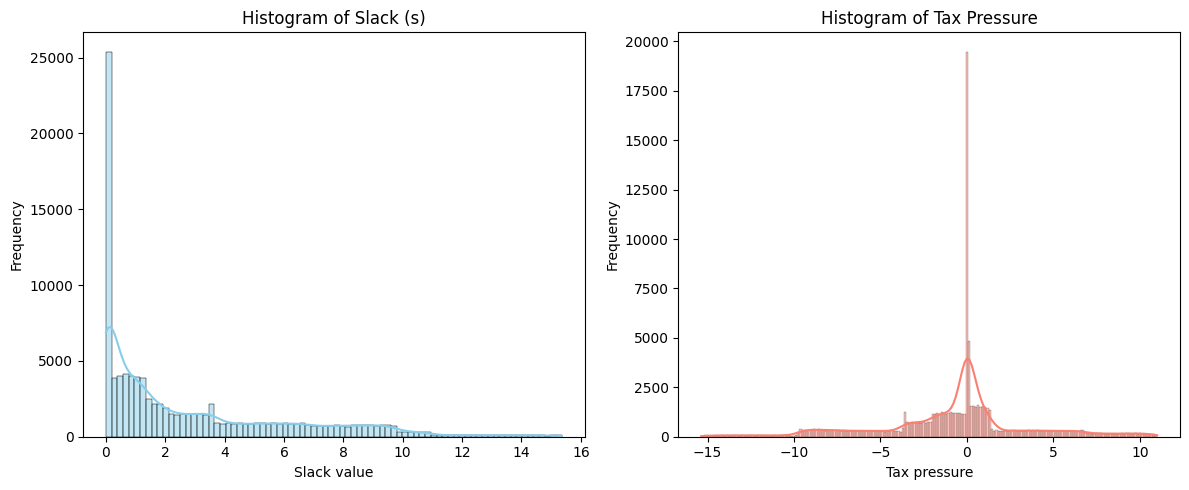

In [102]:
# Get s values
sVals = list(model.s.get_values().values())

# Evaluate tax pressure manually
taxPressureVals = [
    pyo.value(model.tax_pressure[i]) for i in model.taxpayers
]

# Plot with Seaborn
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Slack histogram
sns.histplot(sVals, bins='auto', kde=True, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Slack (s)')
axes[0].set_xlabel('Slack value')
axes[0].set_ylabel('Frequency')

# Tax pressure histogram
sns.histplot(taxPressureVals, bins='auto', kde=True, ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Tax Pressure')
axes[1].set_xlabel('Tax pressure')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: xlabel='tax_group'>

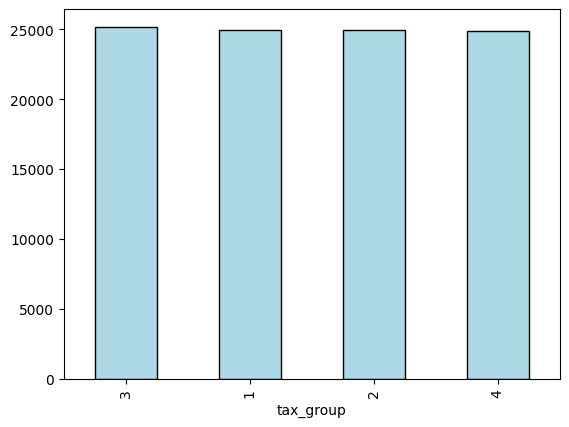

In [103]:
data['tax_group'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')

In [104]:
df = pd.DataFrame({
    'taxGroup': data['tax_group'],
    'taxPressure': taxPressureVals
})

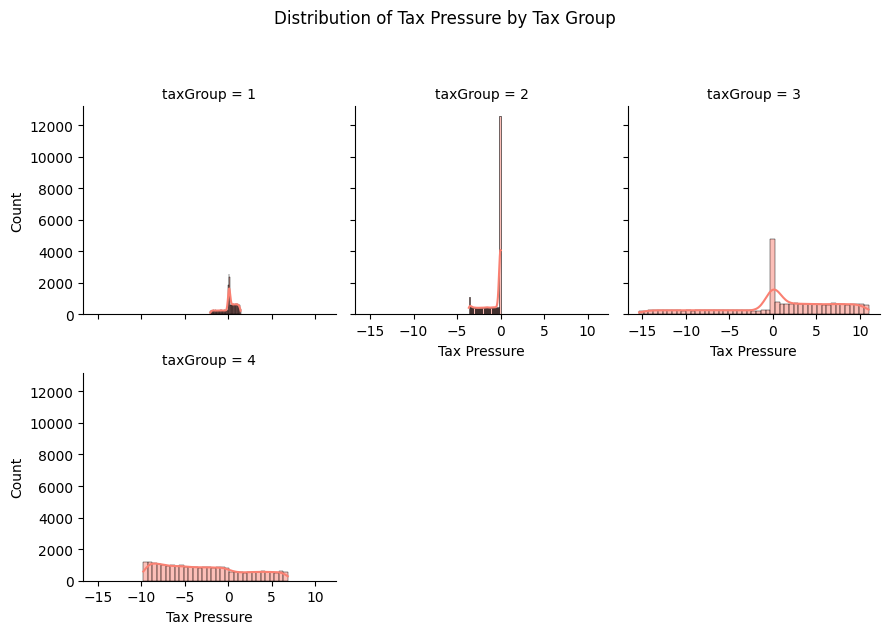

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called `df` and has columns 'taxPressure' and 'taxGroup'
g = sns.FacetGrid(df, col='taxGroup', col_wrap=3, sharex=True, sharey=True)
g.map(sns.histplot, 'taxPressure', kde=True, color='salmon')
g.set_axis_labels("Tax Pressure", "Count")
g.fig.suptitle("Distribution of Tax Pressure by Tax Group", y=1.05)
plt.tight_layout()
plt.show()


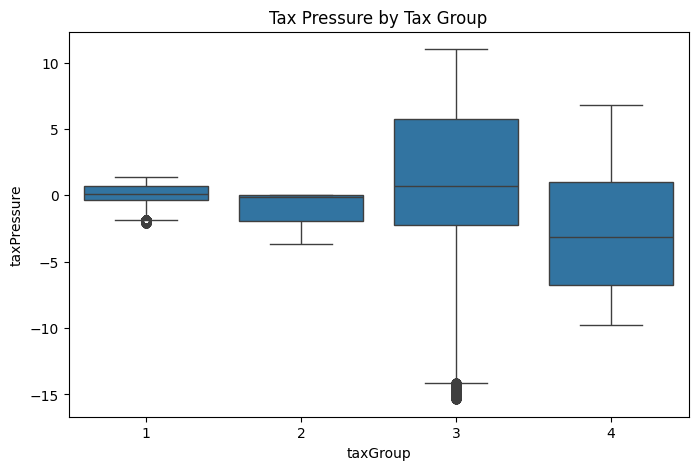

In [106]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='taxGroup', y='taxPressure', data=df)
plt.title("Tax Pressure by Tax Group")
plt.show()


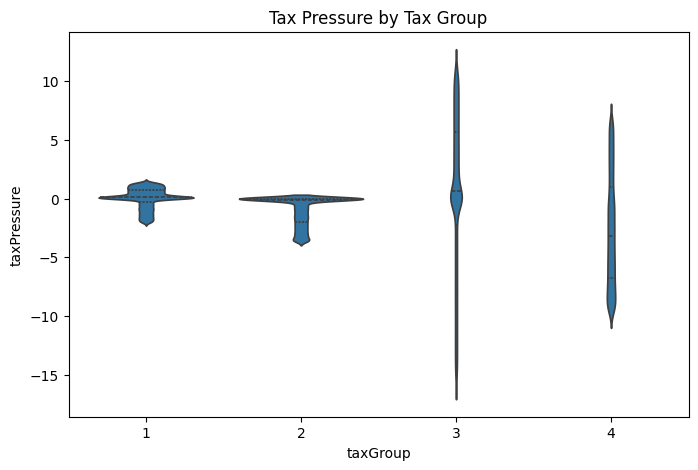

In [107]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='taxGroup', y='taxPressure', data=df, inner='quartile')
plt.title("Tax Pressure by Tax Group")
plt.show()


/var/folders/np/5830zc454wl5c5qp9x0xxypc0000gn/T/ipykernel_78725/3906235806.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='groupSubset', y='taxPressure', ax=axes[0], palette='pastel')
/var/folders/np/5830zc454wl5c5qp9x0xxypc0000gn/T/ipykernel_78725/3906235806.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='groupSubset', y='slack', ax=axes[1], palette='coolwarm')


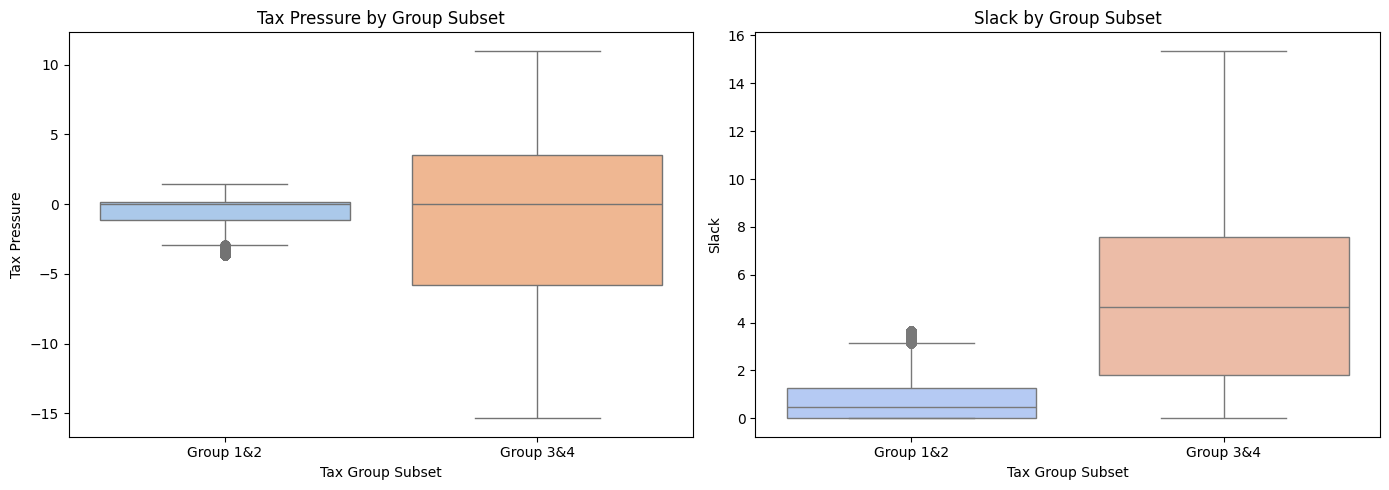

taxPressure                                           
                  count  mean   std    min   25%  50%   75%    max
groupSubset                                                       
Group 1&2       49908.0 -0.46  1.19  -3.64 -1.10 -0.0  0.14   1.41
Group 3&4       50092.0 -1.00  5.98 -15.36 -5.82 -0.0  3.55  11.00

In [120]:
## Group (1&2) vs group (3&4)
df['slack'] = sVals

df['groupSubset'] = df['taxGroup'].map(lambda g: 'Group 1&2' if g in [1, 2] else 'Group 3&4')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='groupSubset', y='taxPressure', ax=axes[0], palette='pastel')
axes[0].set_title('Tax Pressure by Group Subset')
axes[0].set_ylabel('Tax Pressure')
axes[0].set_xlabel('Tax Group Subset')
sns.boxplot(data=df, x='groupSubset', y='slack', ax=axes[1], palette='coolwarm')
axes[1].set_title('Slack by Group Subset')
axes[1].set_ylabel('Slack')
axes[1].set_xlabel('Tax Group Subset')


plt.tight_layout()
plt.show()

summary_stats = df.groupby('groupSubset')[['taxPressure']].describe().round(2)
summary_stats




In [ ]:
times = {b for b in results.summary().columns if 'time' in b.lower()}

In [111]:
results.summary()[sorted({'LogFilePath', 'PresolveTime', 'Runtime', 'NumConstrs', 'NumVars', 'PresolvedNumConstrs', 'PresolvedNumVars', 'NoRelTime', 'NoRelBestBd', 'Status', 'ObjVal', 'RelaxObj', 'RelaxIterCount', 'RelaxTime', 'NodeCount', 'IterCount', 'ObjBound', 'MIPGap', 'SolCount'} & set(results.summary().columns) | times)].round(2)

NameError: name 'times' is not defined

In [112]:
gaps = results.summary().set_index('LogFilePath')['MIPGap'].to_dict()
status = results.summary().set_index('LogFilePath')['Status'].to_dict()
runtime = results.summary().set_index('LogFilePath')['Runtime'].to_dict()

In [113]:
runtime

{'Gurobi_dNegs-False_groups-1_2_3_4_maxBrackets-4_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_Crossover-1_MIPFocus-1_MIPGap-0.001_Method-2_NoRelHeurTime-10.0_Presolve-0_TimeLimit-900.0.log': 42.49,
 'Gurobi_dNegs-False_groups-1_2_3_4_maxBrackets-4_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_MIPFocus-1_MIPGap-0.001_NoRelHeurTime-10.0_Presolve-0_TimeLimit-900.0.log': 39.13,
 'Gurobi_dNegs-False_groups-1_2_3_4_maxBrackets-4_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_MIPGap-0.001_TimeLimit-900.0.log': 89.0,
 'Gurobi_dNegs-False_groups-4_maxBrackets-4_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_Crossover-1_MIPFocus-1_MIPGap-0.001_Method-2_NoRelHeurTime-10.0_Presolve-0_TimeLimit-900.0.log': 13.13,
 'Gurobi_dNegs-False_groups-4_maxBrackets-4_minmax-False_mip_gap-0.001_nRows-None_scale-1000.0_step-5.0_time_limit-900_MIPFocus-1_MIPGap-0.001_NoRelHeurTime-10.0_Presolve-0_T

In [114]:
runs = {
    run: group.reset_index(drop=True)
    for run, group in results.progress().groupby("LogFilePath")
}

In [115]:
def show_these( list_of_runs ):
    for run in list_of_runs:
        runs[run].plot(
            x="Time",           
            y=["BestBd","Incumbent"], 
            figsize=(28, 3),    
            linestyle="-",     
            marker="+",        
            grid=True,         
            title=f'{run} gap={gaps[run]:.4f} {status[run]} {runtime[run]:.1f}',
            xlabel="Time (s)",
            ylabel="Objective Value",
        )
        plt.xlim(0, results.progress().Time.max())
        plt.savefig(f"{str(Path(run).with_suffix('.pdf'))}", dpi=300, bbox_inches='tight')  

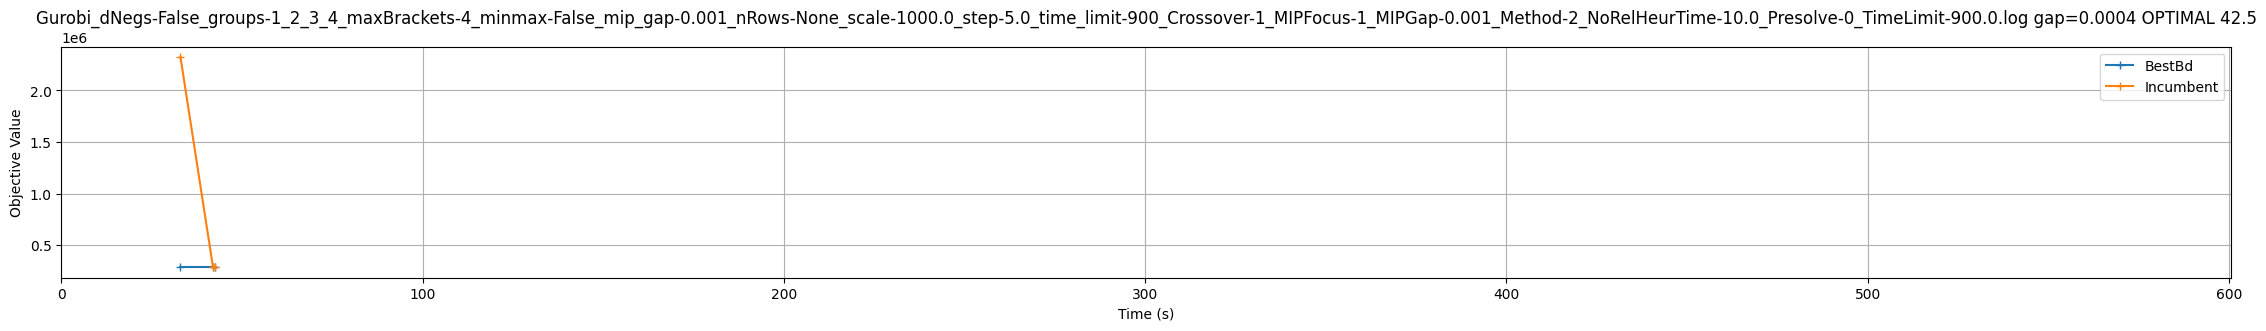

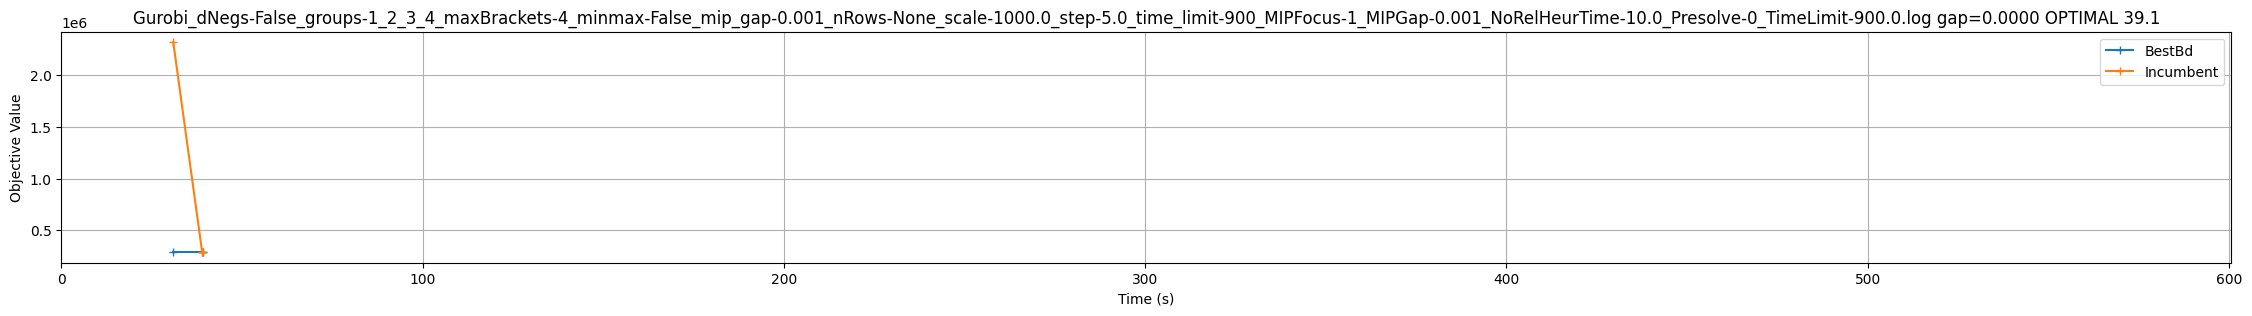

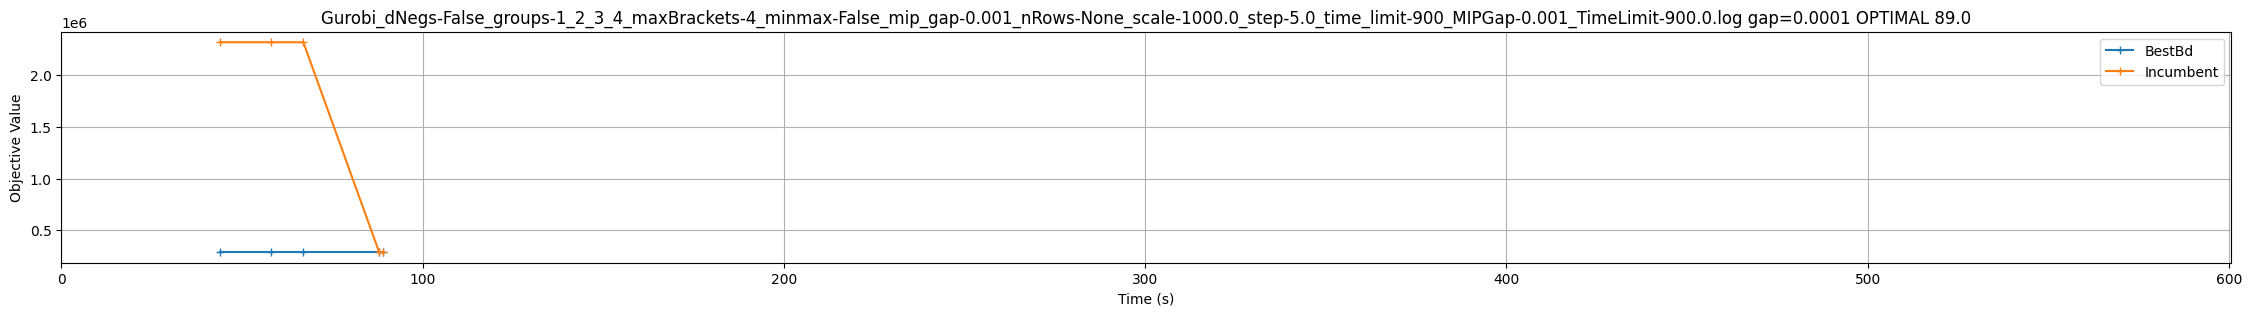

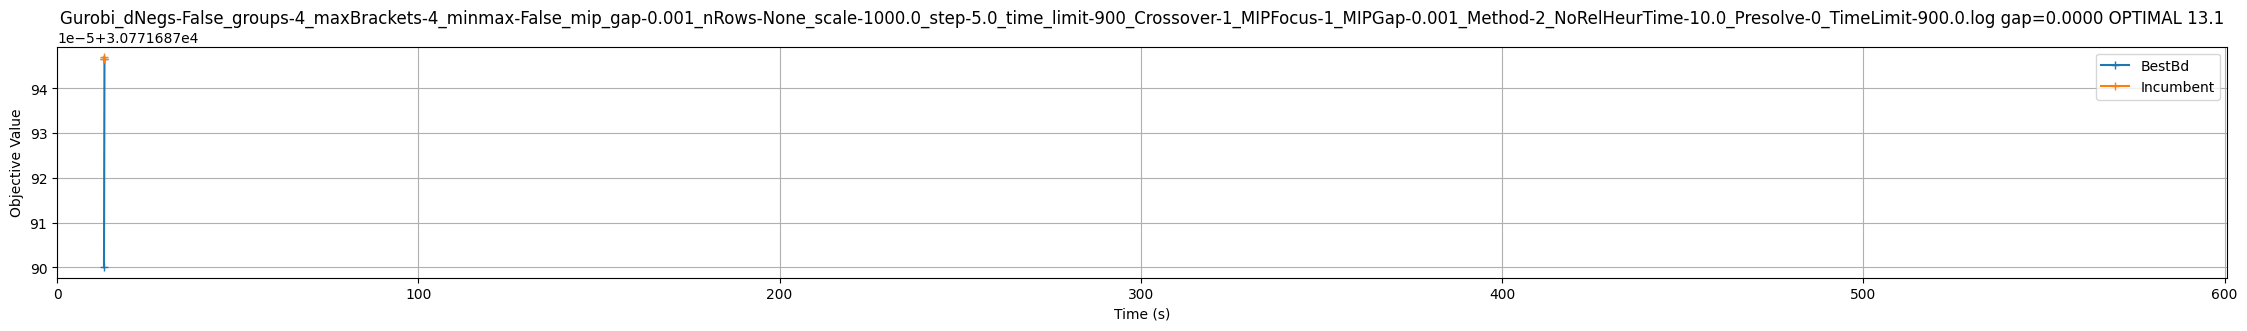

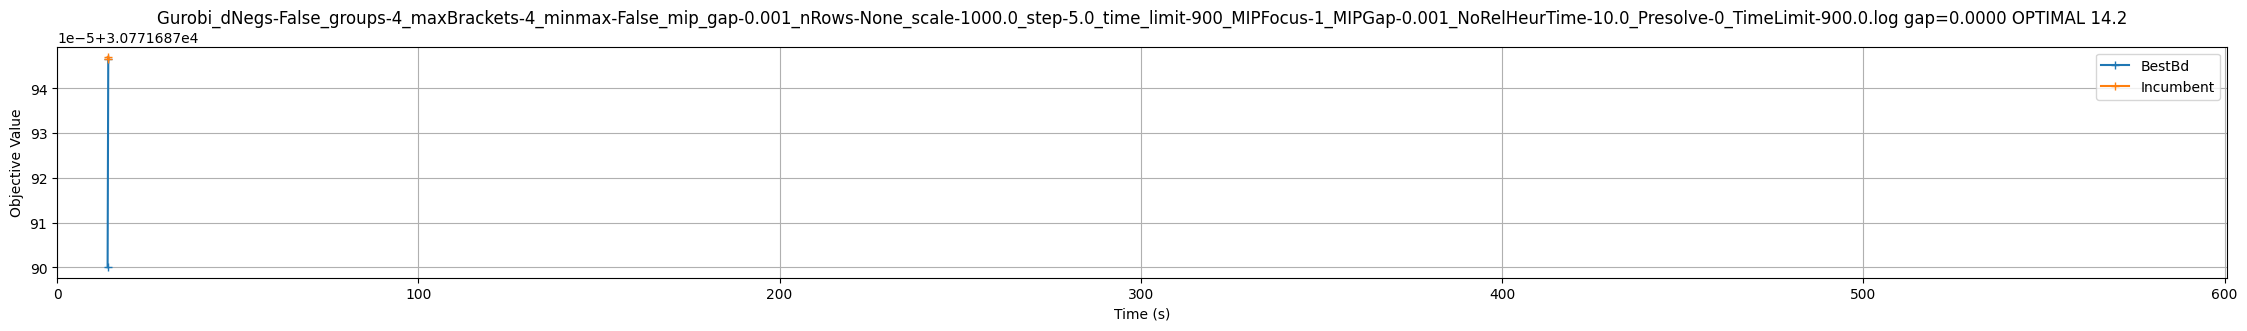

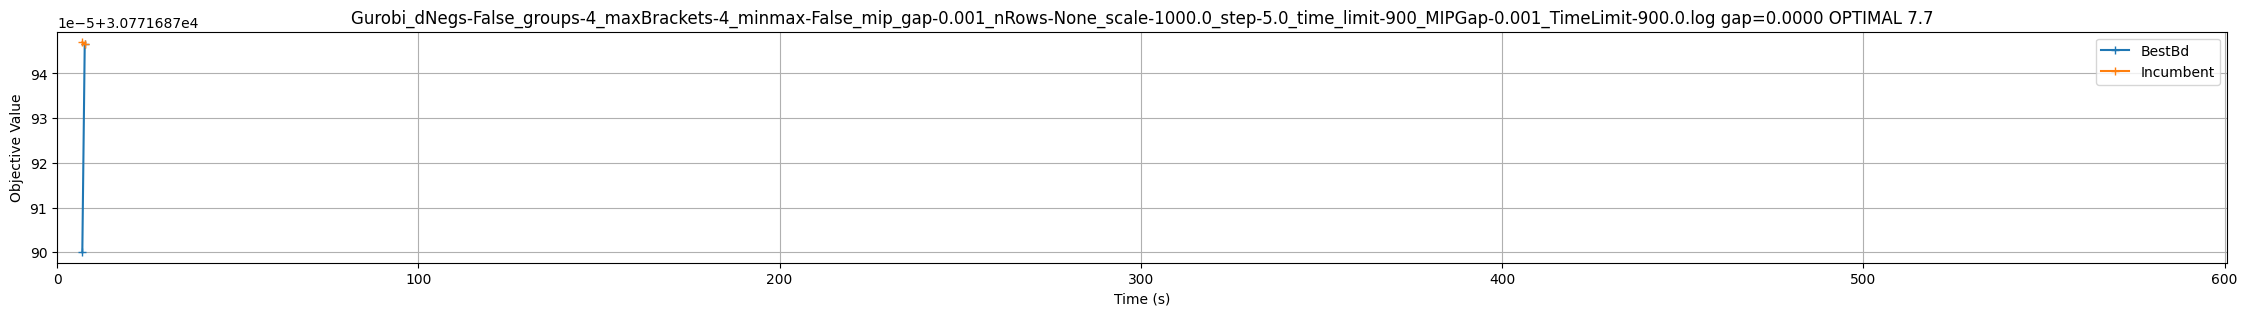

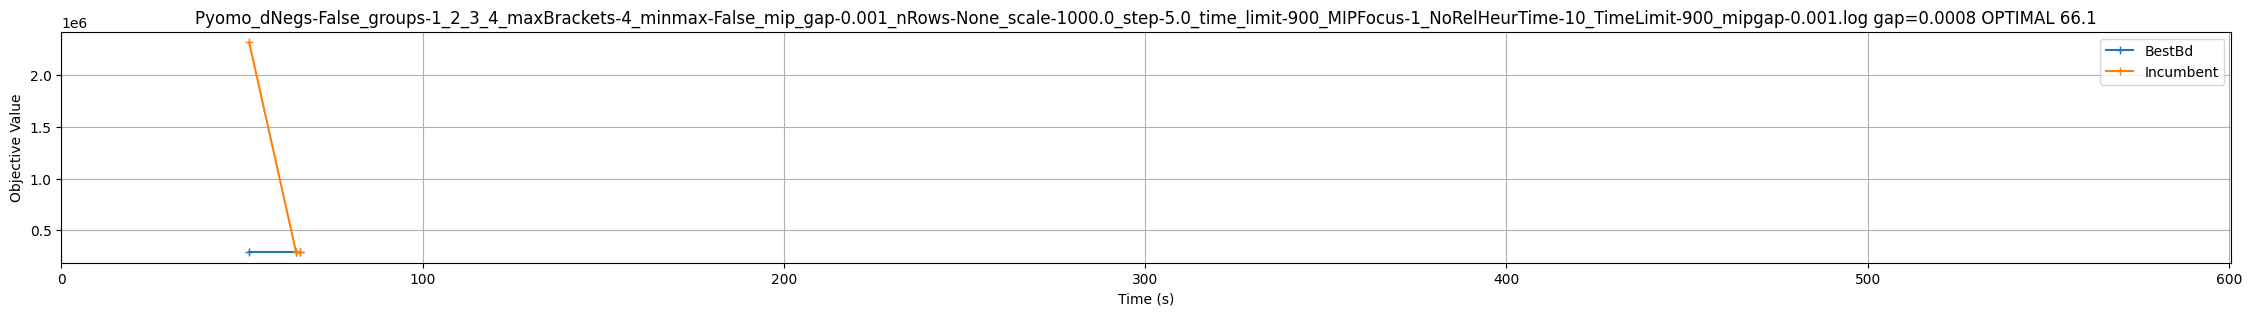

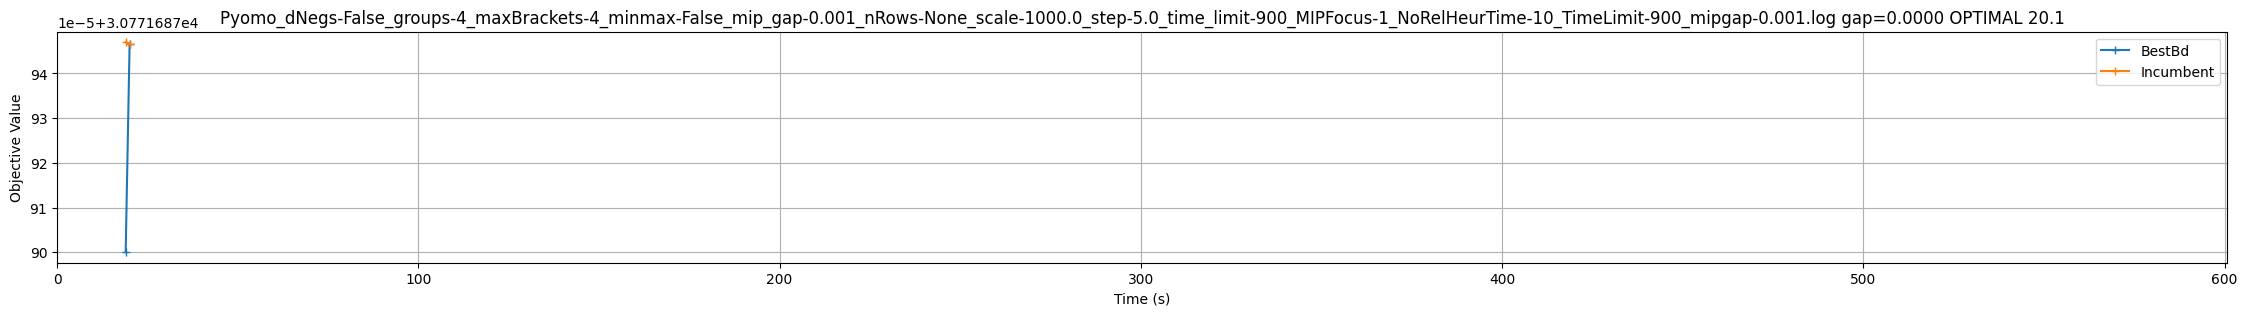

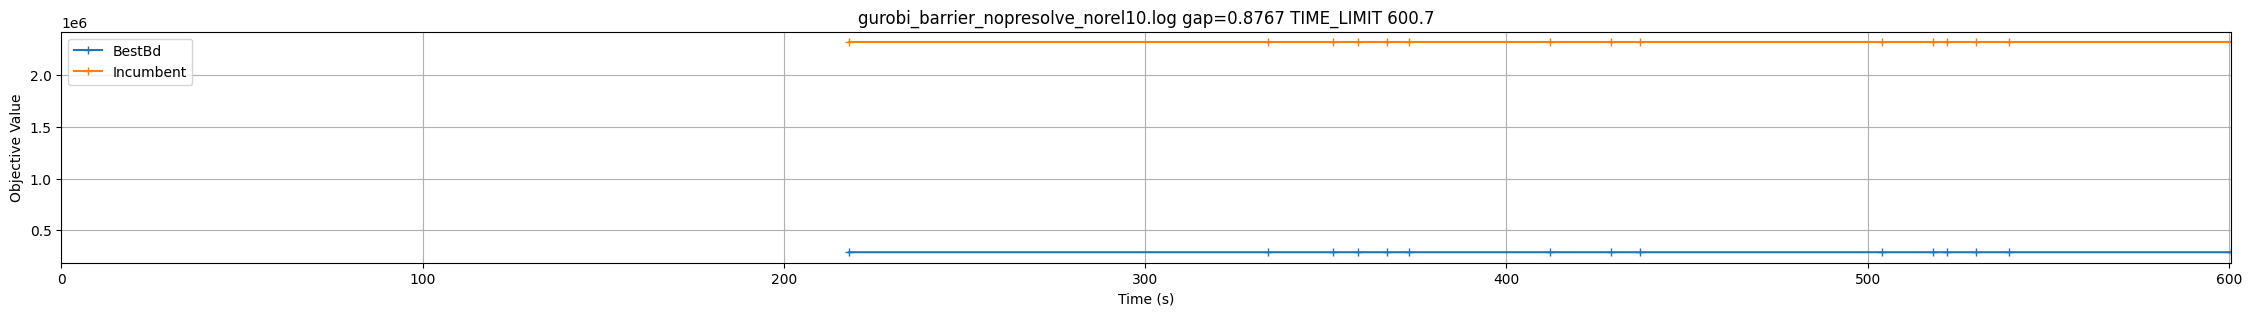

In [116]:
show_these( runs )